In [92]:
import torch
from torch import nn, optim

import matplotlib.pyplot as plt

%matplotlib inline

In [93]:
device = "cpu" # я запускал в google colab и почему-то были проблемы с cuda, я решил пока не думать об этом

In [94]:
mu1 = torch.tensor([10., 3.], device=device, dtype=torch.float32)
mu2 = torch.tensor([6., -1.], device=device, dtype=torch.float32)
covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

p = 0.8
N = 5000

In [95]:
c = torch.distributions.Bernoulli(p). sample((N, ))
a = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N, ))
b = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N, ))

In [96]:
X = torch.FloatTensor([[0, 0] for i in range(N)]) 
X[:, 0] = c * a[:, 0] + (1 - c) * b[:, 0]
X[:, 1] = c * a[:, 1] + (1 - c) * b[:, 1]

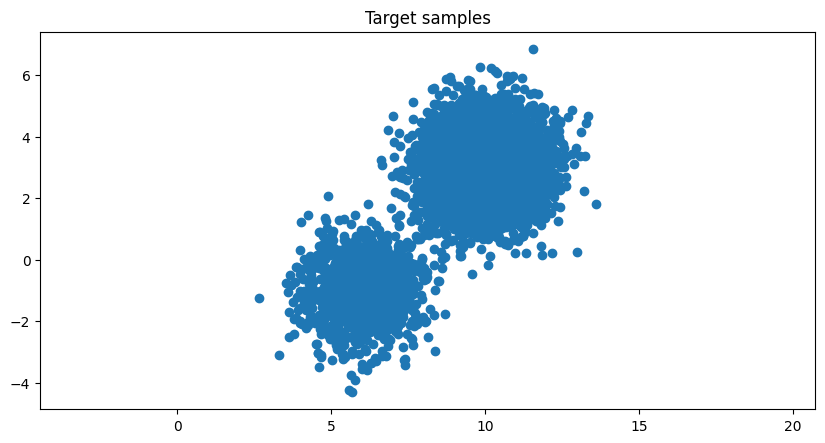

In [97]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(X[:, 0], X[:, 1]);

In [98]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()

    self.fc1 = nn.Linear(2, 1) # for encoder
    self.fc2 = nn.Linear(2, 1)

    self.fc3 = nn.Linear(1, 2) # for decoder

  def encode(self, x):
    return self.fc1(x), self.fc2(x) # mu and logvar -- pframeters of q_{phi}
    
  def reparametrize(self, mu, logvar):
    std = torch.exp(logvar)
    eps = torch.randn_like(std)
    return mu + eps * std
  
  def decode(self, z):
    return self.fc3(z) # mu_0 -- parameter of p_{theta}

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparametrize(mu, logvar)
    return self.decode(z), mu, logvar 

In [99]:
model = VAE()
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

In [104]:
def loss_function(x, mu_0, mu, logvar):
  KL = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()) # KL-divergency
  distr = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=covar)
  ELH = distr.log_prob(x) # 1-MC approximation of expected log likelyhood
  return KL - ELH

In [105]:
for i in range(len(X)):
  input = X[i]
  optimizer.zero_grad()
  mu_0, mu, logvar = model(input)
  loss = loss_function(input, mu_0, mu, logvar)
  loss.backward()
  optimizer.step()

In [106]:
prior = torch.distributions.normal.Normal(0, 1)

In [107]:
pr_samples = prior.sample((1000, ))
pr_samples = torch.tensor([[pr_samples[i]] for i in range(1000)])

In [108]:
mu_0 = model.decode(pr_samples).detach()

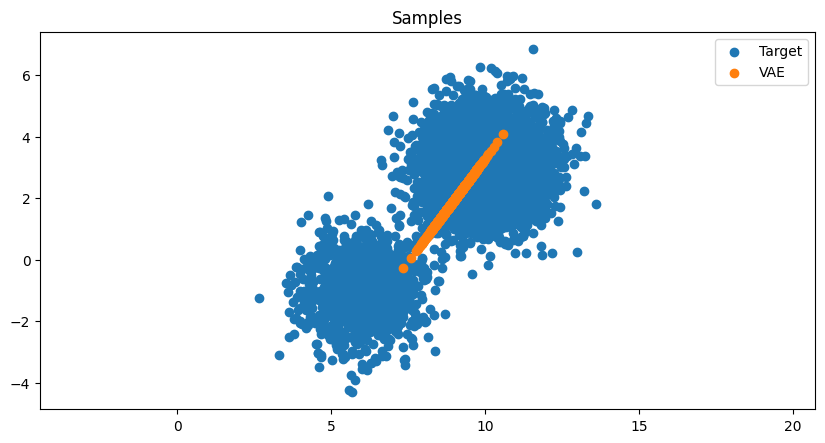

In [109]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0], X[:, 1], label='Target')
plt.scatter(mu_0[:, 0], mu_0[:, 1], label='VAE')
plt.axis('equal')
plt.legend();